In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cnn_modelling.model import MRINet
from cnn_modelling.utils import RMSELoss, SaveBestModelMetrics
from dataset import IXIDataset
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Configuration

In [3]:
PREPROCESSED_SCANS_DIRECTORY = r"/home/dpolak/Downloads/IXI_output_stats_and_final_scans/"
IXI_DEMOGRAPHIC_DATA = r"/home/dpolak/Downloads/IXI.xls"
num_epochs = 50
batch_size = 4

### Loading and splitting the data into train, test and validation

In [7]:
df_main = pd.read_excel(IXI_DEMOGRAPHIC_DATA)
df_main.dropna(inplace=True, subset=("IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"))

In [8]:
train_df, valid_df = train_test_split(df_main, test_size=0.2, random_state=2137, stratify=df_main["SEX_ID (1=m, 2=f)"])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=2137)

In [9]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [11]:
train_dataloader = torch.utils.data.DataLoader(IXIDataset(train_df, PREPROCESSED_SCANS_DIRECTORY, augment=True), batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(IXIDataset(valid_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(IXIDataset(test_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)

Loaded 470 samples.
Loaded 59 samples.
Loaded 59 samples.


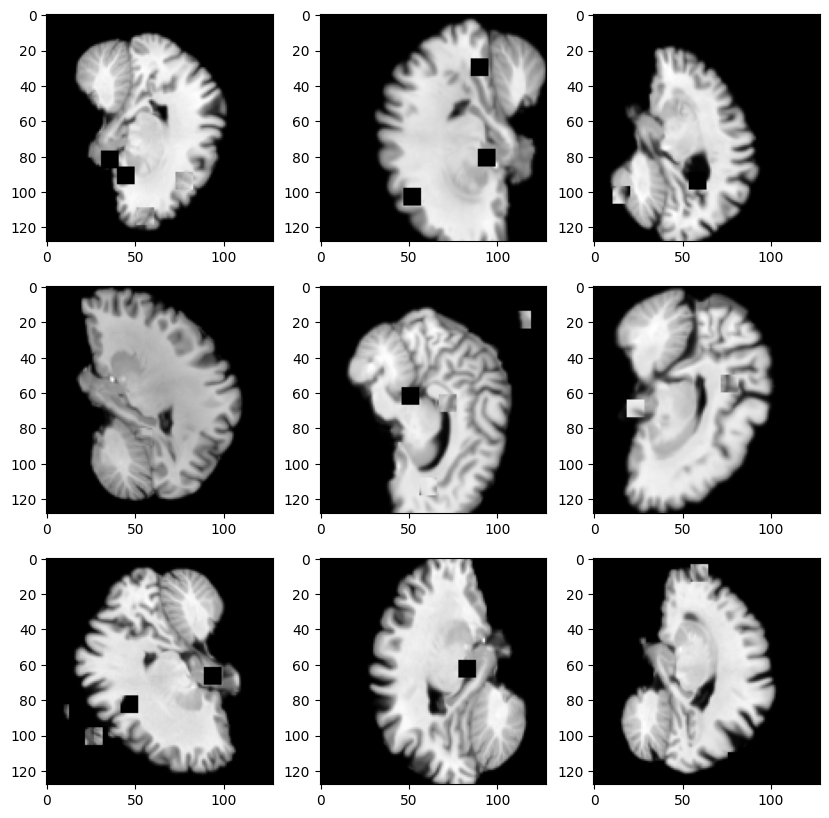

In [13]:
plt.figure(figsize=(10,10))
for i, (image, (_, __)) in enumerate(train_dataloader):
    image = image.cpu().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0, 0, 50, :, :], cmap="gray")
    if i == 8:
        break

## Training the model

In [14]:
model = MRINet()
model = model.to("cuda")

In [15]:
class_weights = (df_main["SEX_ID (1=m, 2=f)"].value_counts().to_numpy() / len(df_main)) ** -1
print(class_weights)

[1.79878049 2.2519084 ]


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_ce = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
criterion_mse = RMSELoss()
save_best = SaveBestModelMetrics(save_path="models/pretrained")
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    train_mse, train_ce, val_ce, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(train_dataloader, leave=True)
    model.train()
    step = 1
    results_sex, ground_truths_sex = [], []
    results_age, ground_truths_age = [], []
    for batch in prbar:
        inputs, (gt_age, gt_sex) = batch
        optimizer.zero_grad()
        output_age, output_sex = model(inputs)
        mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age)
        ce = criterion_ce(output_sex.squeeze().to("cpu"), gt_sex) * 5
        loss = mse + ce
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        train_ce += ce.item()
        
        probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
        results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
        ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
        
        results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
        ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
        
        accuracy = accuracy_score(ground_truths_sex, results_sex)
        balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
        r2 = r2_score(ground_truths_age, results_age)
        
        prbar.set_description(
            f"Epoch: {epoch}, "
            f"Step loss: {round(loss.item(), 3)}, "
            f"Train CE: {round(train_ce / step, 3)}, "
            f"Train RMSE: {round(train_mse / step, 3)}, "
            f"Train Accuracy: {round(accuracy, 3)}, "
            f"Train Balanced Accuracy: {round(balanced_accuracy, 3)},"
            f"Train R2: {round(r2, 3)},"
            f"Running Loss: {round(running_loss / step, 3)}"
        )
        step += 1
        history["train_loss"].append(running_loss / step)
    model.eval()

    with torch.no_grad():
        step = 1
        results_sex, ground_truths_sex = [], []
        results_age, ground_truths_age = [], []
        prbar = tqdm(valid_dataloader, leave=True)
        for batch in prbar:
            inputs, (gt_age, gt_sex) = batch
            output_age, output_sex = model(inputs)
            mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age) 
            ce = criterion_ce(torch.sigmoid(output_sex).squeeze().to("cpu"), gt_sex) * 5
            probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
            
            results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
            ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
            
            results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
            ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
            
            accuracy = accuracy_score(ground_truths_sex, results_sex)
            balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
            r2 = r2_score(ground_truths_age, results_age)
            
            val_mse += mse.item()
            val_ce += ce.item()
            loss = ce + mse
            val_running_loss += loss.item()
            
            prbar.set_description(
                f"Validation epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Valid CE: {round(val_ce / step, 3)}, "
                f"Valid RMSE: {round(val_mse / step, 3)}, "
                f"Valid Accuracy: {round(accuracy, 3)}, "
                f"Valid Balanced Accuracy: {round(balanced_accuracy, 3)},"
                f"Valid R2: {round(r2, 3)},"
                f"Running Loss: {round(val_running_loss / step, 3)}"
            )
            
            step += 1
        history["val_loss"].append(val_running_loss / step)
    save_best(balanced_accuracy + r2, epoch, model)

Epoch: 0, Step loss: 39.372, Train CE: 8.065, Train MSE: 41.057, Train Accuracy: 0.545, Train Balanced Accuracy: 0.522,Train R2: -5.481,Running Loss: 49.122: 100%|██████████| 118/118 [00:51<00:00,  2.30it/s]
Validation epoch: 0, Step loss: 36.944, Valid CE: 6.974, Valid MSE: 37.753, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.61,Valid R2: -4.64,Running Loss: 44.726: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]  



Best validation metric: -4.0301316299533205

Saving best model for epoch: 1


Epoch: 1, Step loss: 25.136, Train CE: 7.922, Train MSE: 23.321, Train Accuracy: 0.547, Train Balanced Accuracy: 0.525,Train R2: -1.245,Running Loss: 31.243: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s]
Validation epoch: 1, Step loss: 12.763, Valid CE: 6.909, Valid MSE: 17.399, Valid Accuracy: 0.542, Valid Balanced Accuracy: 0.5,Valid R2: -0.273,Running Loss: 24.307: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]



Best validation metric: 0.22726416337103772

Saving best model for epoch: 2


Epoch: 2, Step loss: 23.145, Train CE: 8.598, Train MSE: 16.051, Train Accuracy: 0.53, Train Balanced Accuracy: 0.511,Train R2: -0.012,Running Loss: 24.649: 100%|██████████| 118/118 [00:46<00:00,  2.56it/s] 
Validation epoch: 2, Step loss: 17.522, Valid CE: 6.886, Valid MSE: 14.869, Valid Accuracy: 0.525, Valid Balanced Accuracy: 0.487,Valid R2: 0.078,Running Loss: 21.755: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]



Best validation metric: 0.5655384979447061

Saving best model for epoch: 3


Epoch: 3, Step loss: 21.888, Train CE: 7.79, Train MSE: 15.133, Train Accuracy: 0.583, Train Balanced Accuracy: 0.565,Train R2: 0.109,Running Loss: 22.923: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s] 
Validation epoch: 3, Step loss: 23.285, Valid CE: 6.814, Valid MSE: 14.613, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.519,Valid R2: 0.131,Running Loss: 21.427: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]



Best validation metric: 0.6497152518989054

Saving best model for epoch: 4


Epoch: 4, Step loss: 31.582, Train CE: 7.875, Train MSE: 14.545, Train Accuracy: 0.568, Train Balanced Accuracy: 0.546,Train R2: 0.168,Running Loss: 22.421: 100%|██████████| 118/118 [00:43<00:00,  2.70it/s]
Validation epoch: 4, Step loss: 24.983, Valid CE: 6.985, Valid MSE: 16.126, Valid Accuracy: 0.61, Valid Balanced Accuracy: 0.615,Valid R2: -0.002,Running Loss: 23.111: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s] 
Epoch: 5, Step loss: 26.693, Train CE: 7.954, Train MSE: 13.799, Train Accuracy: 0.557, Train Balanced Accuracy: 0.539,Train R2: 0.239,Running Loss: 21.753: 100%|██████████| 118/118 [00:43<00:00,  2.70it/s]
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 5, Step loss: 21.256, Valid CE: 6.877, Valid MSE: 11.71, Valid Accuracy: 0.525, Valid Balanced Accuracy


Best validation metric: 0.9552407285407438

Saving best model for epoch: 6


Epoch: 6, Step loss: 23.076, Train CE: 8.09, Train MSE: 12.935, Train Accuracy: 0.534, Train Balanced Accuracy: 0.516,Train R2: 0.322,Running Loss: 21.024: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s] 
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 6, Step loss: 15.835, Valid CE: 6.908, Valid MSE: 10.307, Valid Accuracy: 0.492, Valid Balanced Accuracy: 0.462,Valid R2: 0.58,Running Loss: 17.215: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s] 



Best validation metric: 1.042066847875279

Saving best model for epoch: 7


Epoch: 7, Step loss: 15.868, Train CE: 8.054, Train MSE: 12.74, Train Accuracy: 0.577, Train Balanced Accuracy: 0.552,Train R2: 0.347,Running Loss: 20.793: 100%|██████████| 118/118 [00:43<00:00,  2.72it/s] 
Validation epoch: 7, Step loss: 26.763, Valid CE: 7.122, Valid MSE: 10.661, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.588,Valid R2: 0.533,Running Loss: 17.783: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]



Best validation metric: 1.120682422834796

Saving best model for epoch: 8


Epoch: 8, Step loss: 21.089, Train CE: 7.068, Train MSE: 12.52, Train Accuracy: 0.594, Train Balanced Accuracy: 0.574,Train R2: 0.358,Running Loss: 19.588: 100%|██████████| 118/118 [00:43<00:00,  2.70it/s] 
Validation epoch: 8, Step loss: 17.59, Valid CE: 6.675, Valid MSE: 9.963, Valid Accuracy: 0.542, Valid Balanced Accuracy: 0.5,Valid R2: 0.593,Running Loss: 16.637: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s] 
Epoch: 9, Step loss: 29.371, Train CE: 7.537, Train MSE: 12.77, Train Accuracy: 0.579, Train Balanced Accuracy: 0.556,Train R2: 0.334,Running Loss: 20.307: 100%|██████████| 118/118 [00:44<00:00,  2.65it/s] 
Validation epoch: 9, Step loss: 13.829, Valid CE: 6.759, Valid MSE: 10.821, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.595,Valid R2: 0.526,Running Loss: 17.58: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s] 



Best validation metric: 1.1211290464883048

Saving best model for epoch: 10


Epoch: 10, Step loss: 26.703, Train CE: 7.482, Train MSE: 11.993, Train Accuracy: 0.581, Train Balanced Accuracy: 0.56,Train R2: 0.392,Running Loss: 19.475: 100%|██████████| 118/118 [00:43<00:00,  2.71it/s] 
Validation epoch: 10, Step loss: 29.449, Valid CE: 6.762, Valid MSE: 13.612, Valid Accuracy: 0.576, Valid Balanced Accuracy: 0.537,Valid R2: 0.298,Running Loss: 20.374: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
Epoch: 11, Step loss: 9.759, Train CE: 7.335, Train MSE: 11.89, Train Accuracy: 0.57, Train Balanced Accuracy: 0.553,Train R2: 0.414,Running Loss: 19.225: 100%|██████████| 118/118 [00:44<00:00,  2.67it/s]   
Validation epoch: 11, Step loss: 16.678, Valid CE: 6.681, Valid MSE: 9.855, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.519,Valid R2: 0.615,Running Loss: 16.536: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s] 



Best validation metric: 1.1333732348245458

Saving best model for epoch: 12


Epoch: 12, Step loss: 19.629, Train CE: 7.188, Train MSE: 12.648, Train Accuracy: 0.589, Train Balanced Accuracy: 0.562,Train R2: 0.352,Running Loss: 19.836: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]
Validation epoch: 12, Step loss: 19.409, Valid CE: 6.798, Valid MSE: 10.929, Valid Accuracy: 0.729, Valid Balanced Accuracy: 0.712,Valid R2: 0.538,Running Loss: 17.726: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]



Best validation metric: 1.2507411043022825

Saving best model for epoch: 13


Epoch: 13, Step loss: 21.51, Train CE: 6.65, Train MSE: 12.45, Train Accuracy: 0.64, Train Balanced Accuracy: 0.621,Train R2: 0.365,Running Loss: 19.1: 100%|██████████| 118/118 [00:43<00:00,  2.71it/s]      
Validation epoch: 13, Step loss: 27.123, Valid CE: 6.705, Valid MSE: 13.841, Valid Accuracy: 0.593, Valid Balanced Accuracy: 0.561,Valid R2: 0.224,Running Loss: 20.545: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
Epoch: 14, Step loss: 35.553, Train CE: 7.184, Train MSE: 12.429, Train Accuracy: 0.591, Train Balanced Accuracy: 0.572,Train R2: 0.383,Running Loss: 19.613: 100%|██████████| 118/118 [00:41<00:00,  2.82it/s]
Validation epoch: 14, Step loss: 12.398, Valid CE: 6.629, Valid MSE: 10.279, Valid Accuracy: 0.542, Valid Balanced Accuracy: 0.5,Valid R2: 0.568,Running Loss: 16.909: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
Epoch: 15, Step loss: 16.607, Train CE: 7.609, Train MSE: 11.719, Train Accuracy: 0.57, Train Balanced Accuracy: 0.544,Train R2: 0.417,Running Loss: 19.


Best validation metric: 1.405471661344003

Saving best model for epoch: 30


Epoch: 30, Step loss: 7.375, Train CE: 5.778, Train MSE: 11.183, Train Accuracy: 0.687, Train Balanced Accuracy: 0.673,Train R2: 0.467,Running Loss: 16.961: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s] 
Validation epoch: 30, Step loss: 20.562, Valid CE: 6.399, Valid MSE: 13.653, Valid Accuracy: 0.746, Valid Balanced Accuracy: 0.737,Valid R2: 0.233,Running Loss: 20.053: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
Epoch: 31, Step loss: 17.446, Train CE: 6.222, Train MSE: 10.928, Train Accuracy: 0.655, Train Balanced Accuracy: 0.64,Train R2: 0.502,Running Loss: 17.15: 100%|██████████| 118/118 [00:42<00:00,  2.81it/s]  
Validation epoch: 31, Step loss: 24.532, Valid CE: 6.661, Valid MSE: 24.374, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.598,Valid R2: -1.39,Running Loss: 31.035: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s] 
Epoch: 32, Step loss: 22.022, Train CE: 5.947, Train MSE: 11.065, Train Accuracy: 0.666, Train Balanced Accuracy: 0.648,Train R2: 0.499,Running Loss:


Best validation metric: 1.4957972201209488

Saving best model for epoch: 36


Epoch: 36, Step loss: 9.24, Train CE: 5.85, Train MSE: 10.837, Train Accuracy: 0.679, Train Balanced Accuracy: 0.663,Train R2: 0.51,Running Loss: 16.686: 100%|██████████| 118/118 [00:43<00:00,  2.74it/s]    
Validation epoch: 36, Step loss: 20.864, Valid CE: 6.501, Valid MSE: 12.286, Valid Accuracy: 0.695, Valid Balanced Accuracy: 0.681,Valid R2: 0.386,Running Loss: 18.787: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
Epoch: 37, Step loss: 17.849, Train CE: 6.361, Train MSE: 10.792, Train Accuracy: 0.66, Train Balanced Accuracy: 0.637,Train R2: 0.519,Running Loss: 17.153: 100%|██████████| 118/118 [00:43<00:00,  2.73it/s] 
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 37, Step loss: 14.471, Valid CE: 6.388, Valid MSE: 15.212, Valid Accuracy: 0.678, Valid Balanced Accu


Best validation metric: 1.5067594880753954

Saving best model for epoch: 50


### Evaluation on the test set

In [17]:
model.load_state_dict(torch.load(f"/home/dpolak/dsc-2023-mri-classification/cnn_modelling/models/pretrained/best_model.pth"))
model.eval()
test_results_age = []
test_ground_truths_age = []
test_results_sex = []
test_ground_truths_sex = []
for test_batch in test_dataloader:
    output_age, output_sex = model.forward(test_batch[0])
    test_results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
    test_ground_truths_age.extend(test_batch[1][0].squeeze().to("cpu").detach().numpy())
    test_results_sex.extend(torch.argmax(torch.softmax(output_sex, dim=1), dim=1).to("cpu").detach().numpy())
    test_ground_truths_sex.extend(torch.argmax(test_batch[1][1], dim=1))
    
test_accuracy = accuracy_score(test_ground_truths_sex, test_results_sex, normalize=True)
test_balanced_accuracy = balanced_accuracy_score(test_ground_truths_sex, test_results_sex,  adjusted=False)
test_mse = mean_squared_error(test_ground_truths_age, test_results_age)
test_mae = mean_absolute_error(test_ground_truths_age, test_results_age)
test_r2 = r2_score(test_ground_truths_age, test_results_age)
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print(f"Test Balanced Accuracy: {round(test_balanced_accuracy, 3)}")
print(f"Test MSE: {round(test_mse, 3)}")
print(f"Test MAE: {round(test_mae, 3)}")
print(f"Test R2: {round(test_r2, 3)}")

Test Accuracy: 0.814
Test Balanced Accuracy: 0.806
Test MSE: 71.3270034790039
Test MAE: 7.021999835968018
Test R2: 0.768


In [18]:
np.concatenate((np.array(test_results_age).reshape(-1, 1), np.array(test_ground_truths_age).reshape(-1, 1)), axis=1)

array([[26.963243, 26.579056],
       [28.447767, 26.272417],
       [68.35996 , 63.41684 ],
       [73.374214, 72.09035 ],
       [33.26544 , 28.24367 ],
       [61.64385 , 58.28063 ],
       [28.437258, 25.938398],
       [30.817541, 34.01232 ],
       [38.054226, 31.59206 ],
       [33.517494, 20.16701 ],
       [58.818916, 61.99589 ],
       [28.448757, 27.014374],
       [52.50899 , 58.78166 ],
       [46.36042 , 44.093086],
       [63.394333, 72.1451  ],
       [72.993645, 68.481865],
       [44.48752 , 56.963722],
       [69.86542 , 74.01232 ],
       [41.696476, 31.849419],
       [58.70135 , 64.66256 ],
       [68.17444 , 59.471596],
       [46.25164 , 55.827515],
       [43.633656, 48.05202 ],
       [31.349741, 26.984257],
       [62.220715, 69.067764],
       [61.408546, 66.275154],
       [39.83514 , 24.895277],
       [31.62322 , 25.18549 ],
       [59.246334, 67.53457 ],
       [46.786625, 41.059547],
       [36.3606  , 22.570843],
       [57.87295 , 63.540043],
       [

In [19]:
np.concatenate((np.array(test_results_sex).reshape(-1,1), np.array(test_ground_truths_sex).reshape(-1,1)), axis=1)

array([[0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1]])